In [1]:
'''
Date: 2023/Jan/1
Author: Yike Xie
Content: Create the fluorescent matrix of lipofuscion according to existing publications
'''

'\nDate: 2022/Dec/22\nAuthor: Yike Xie\nContent: Create the fluorescent matrix of NADP according to existing publications\n'

In [2]:
# paper: https://reader.elsevier.com/reader/sd/pii/0042698990900034?token=D41BC03F575160A5EC096742C1217262C94C402600979EB5C648A76E3D2CB1C559E2EE1DA141E642E0BE637D44DB680D&originRegion=us-east-1&originCreation=20230101024519

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import seaborn as sns

In [2]:
wls =np.array([
 (325, 414),
 (343, 414),#
 (370, 414),
 (343, 451),
 (370, 451),
 (373, 451),
 (343, 575),#
 (393, 575),
 (406, 575),
 (441, 575),
 (400, 594),
 (406, 594),
 (431, 594),
 (480, 594),#
 (339, 575),
])

In [81]:
def load_figure(fmt_fn, fmt_fn1):
    rgba_image = PIL.Image.open(fmt_fn)
    rgb_image = rgba_image.convert('RGB')
    rgb_image.save(fmt_fn1)

    # load as a RGB image
    fmt = plt.imread(fmt_fn1)
    fmt *= 255
    fmt = fmt.astype(int)

    plt.imshow(fmt)
    plt.axis('off')
    
    return fmt

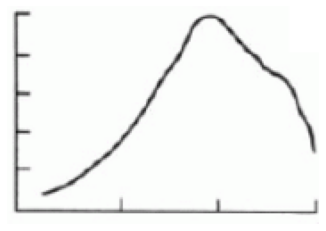

In [97]:
fdn = '/home/yike/phd/cancer_cells_img_seq/scripts/spetra_matrixs/'
fmt = {}
for n in ['A', 'B', 'C']:
    fn1 = fdn + 'lipofuscion' + n + '1.png'
    fn1new = fdn + 'lipofuscion' + n + '1RGB.png'
    fmt[n + '1'] = load_figure(fn1, fn1new)
    
    fn2 = fdn + 'lipofuscion' + n + '2.png'
    fn2new = fdn + 'lipofuscion' + n + '2RGB.png'
    fmt[n + '2'] = load_figure(fn2, fn2new)

In [126]:
def get_array(fmt):
    w = fmt.shape[1]
    l = fmt.shape[0]
    
    K = ((fmt[:, :, 0] < 150) & (fmt[:, :, 1] < 150) & (fmt[:, :, 2] < 150))

    # center
    cx = pd.Series(fmt[:, :, :].sum(axis=2).sum(axis=0), index=range(w)).sort_values().index[0] # x axis 70
    cy = pd.Series(fmt[:, :, :].sum(axis=2).sum(axis=1), index=range(l)).sort_values().index[0] # y axis 214

    # x axis, max
    x = pd.Series(fmt[:, :, :].sum(axis=2)[cy, :], index=range(w))
    # xmin = x[x < 100].index[0]
    xmax = x[x < 400].index[-1]

    # y axis, min
    y = pd.Series(fmt[:, :, :].sum(axis=2)[:, cx], index=range(l))
    ymin = y[y < 400].index[0]  # upper
    # ymax = y[y < 100].index[-1] # lower
    
    fig, axs = plt.subplots(1, 3, figsize=[10, 3])
    
    axs[0].imshow(K)
    
    axs[1].imshow(K)
    axs[1].imshow(K)
    axs[1].scatter(cx, cy, c='red', s=10)
    axs[1].scatter(cx, ymin, c='red', s=10)
    axs[1].scatter(xmax, cy, c='red', s=10)
    
    axs[2].imshow(fmt)
    
    return {'K': K, 'cx': cx, 'xmax': xmax, 'cy': cy, 'ymin': ymin}

def pureK(ems_dic):
    K, cx, cy = ems_dic['K'], ems_dic['cx'], ems_dic['cy']
    fmt = K.copy()
    fmt[:, :cx] = False
    fmt[:cy, :cx + 10] = False

    fmt[cy - 10:, :] = False
    plt.imshow(fmt)
    
    return fmt

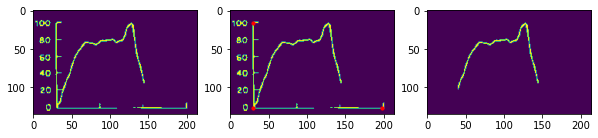

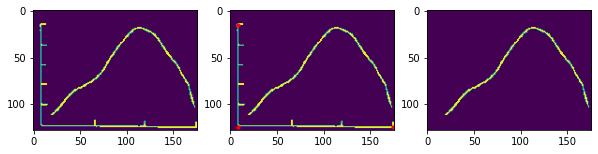

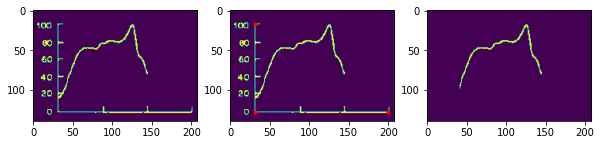

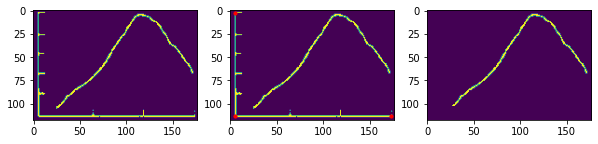

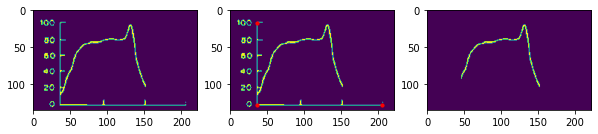

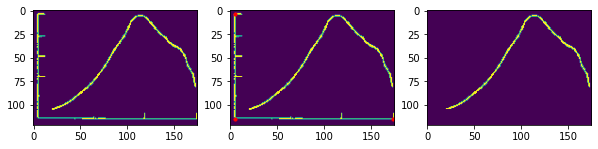

In [127]:
array_dic = {}
for name, fmti in fmt.items():
    dic = get_array(fmti)
    array_dic[name] = dic
    Ki = pureK(dic)
    array_dic[name]['K'] = Ki

In [236]:
def get_ratio(ems_dic, C, imin, imax, wmin, wmax):
    C, K, cx, xmax, cy, ymin = ems_dic[C], ems_dic['K'], ems_dic['cx'], ems_dic['xmax'], ems_dic['cy'], ems_dic['ymin']
    ems = np.argwhere(C) # [y, x] [:, 1] x, [:, 0] y
    
    # emission wavelengths and fluorescent intensity
    em_its = {(x - cx) * (wmax - wmin) / (xmax - cx) + wmin : (imax - imin) * (cy - y) / (cy - ymin) + imin 
              for y, x  in ems}
    
    fig, axs = plt.subplots(2, figsize=(4, 3))
    axs[0].imshow(K)
    axs[0].scatter(ems[:, 1], ems[:, 0], color='red', s=5)

    axs[1].set_xlim(wmin, wmax)
    axs[1].set_ylim(imin, imax)
    axs[1].scatter(em_its.keys(), em_its.values(), color='red', s=5)
    axs[1].set_xlabel('Wavelengths (nm)')
    axs[1].set_ylabel('Fluorescent intensity')
    
    # emission wavelengths and fluorescent ratio
    em_it_max = max(em_its.values())
    import math
    em_ratio = {round(k, 1): v / em_it_max for k, v in em_its.items()}
    
    return em_ratio

def matrix(ex_ratio, em_ratio, name):
    # create the matrix and plot
    columns = list(ex_ratio.keys())
    columns.sort()
    index = list(em_ratio.keys())
    index.sort()
    index = index[::-1]

    df = pd.DataFrame(np.zeros(shape=(len(index), len(columns))), 
                          index=index, columns=columns)

    for x in ex_ratio.keys():
        for y in em_ratio.keys():
            df.at[y, x] = ex_ratio[x] * em_ratio[y]
    
    fdn = '/home/yike/phd/cancer_cells_img_seq/scripts/spetra_matrixs/heatmap/'
    df.to_csv(fdn + name + '_FL_ratio_matrix.tsv', sep='\t')

    fig, ax = plt.subplots()
    sns.heatmap(df, cmap='viridis', ax=ax)
    ax.set_xlabel('Excitation Wavelength (nm)')
    ax.set_ylabel('Emission Wavelength (nm)')
    ax.set_title(name)

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xmin, xmax = df.columns.min(), df.columns.max()
    ymin, ymax = df.index.min(), df.index.max()
    sx = [(i - xmin) * (xlim[1] - xlim[0]) / (xmax - xmin) + xlim[0] for i in wls[:, 0].tolist()]
    sy = [(i - ymin) * (ylim[1] - ylim[0]) / (ymax - ymin) + ylim[0] for i in wls[:, 1].tolist()]

    handles, labels = ax.get_legend_handles_labels()
    colors = sns.color_palette('hls', 15)
    for i, txt in enumerate(range(1, 16)):
        ax.scatter(sx[i], sy[i], color=colors[i], s=50)
        handles.append(ax.scatter([], [], color=colors[i], s=50)) 

    ax.legend(handles=handles, labels = [str(i) for i in wls], bbox_to_anchor=(1.2, 1.05))
    plt.savefig(fdn + name + '.png', dpi=300, bbox_inches='tight')
    
    return df

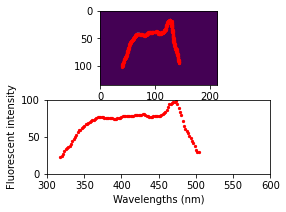

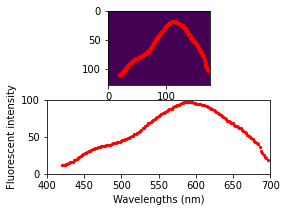

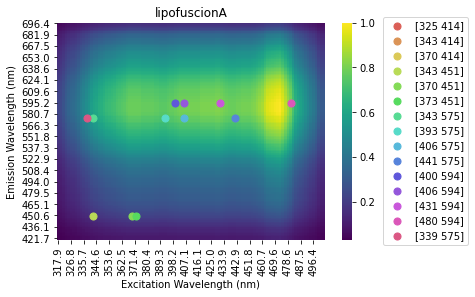

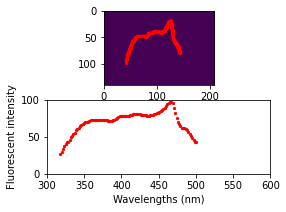

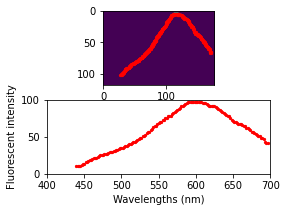

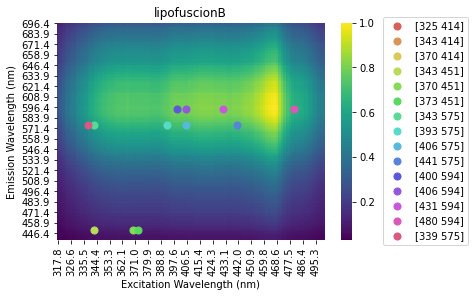

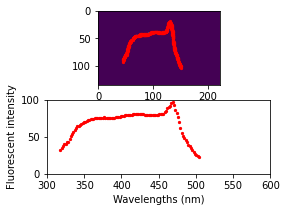

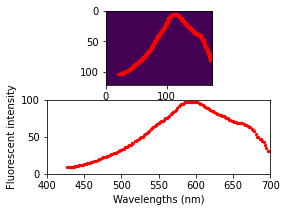

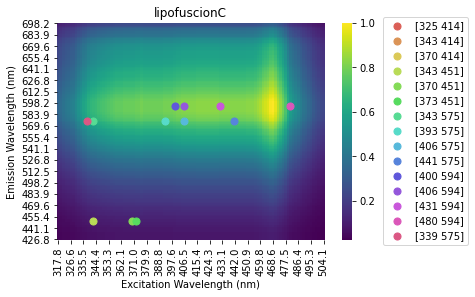

In [237]:
df = {}
for n in ['A', 'B', 'C']:
    name = 'lipofuscion' + n
    ex_ratio = get_ratio(array_dic[n + '1'], 'K', 0, 100, 300, 600)
    em_ratio = get_ratio(array_dic[n + '2'], 'K', 0, 100, 400, 700)
    dfi = matrix(ex_ratio, em_ratio, name)
    df[name] = dfi

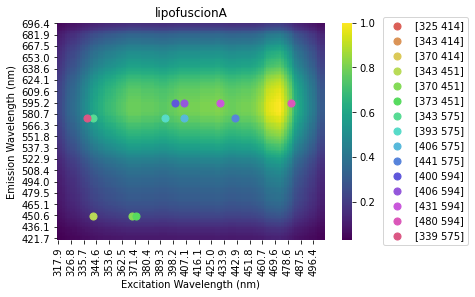

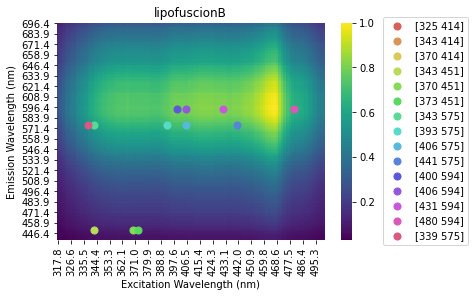

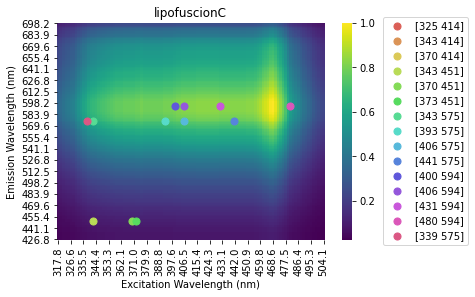

In [9]:
    for n in ['A', 'B', 'C']:
        name = 'lipofuscion' + n
        fdn = '/home/yike/phd/cancer_cells_img_seq/scripts/spetra_matrixs/heatmap/' 
        fn = fdn + name + '_FL_ratio_matrix.tsv'
        df = pd.read_csv(fn, sep='\t', index_col=0)
        
        fig, ax = plt.subplots()
        sns.heatmap(df, cmap='viridis', ax=ax)
        ax.set_xlabel('Excitation Wavelength (nm)')
        ax.set_ylabel('Emission Wavelength (nm)')
        ax.set_title(name)

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        xmin, xmax = min([float(i) for i in df.columns]), max([float(i) for i in df.columns])
        ymin, ymax = df.index.min(), df.index.max()
        sx = [(i - xmin) * (xlim[1] - xlim[0]) / (xmax - xmin) + xlim[0] for i in wls[:, 0].tolist()]
        sy = [(i - ymin) * (ylim[1] - ylim[0]) / (ymax - ymin) + ylim[0] for i in wls[:, 1].tolist()]

        handles, labels = ax.get_legend_handles_labels()
        colors = sns.color_palette('hls', 15)
        for i, txt in enumerate(range(1, 16)):
            ax.scatter(sx[i], sy[i], color=colors[i], s=50)
            handles.append(ax.scatter([], [], color=colors[i], s=50)) 

        ax.legend(handles=handles, labels = [str(i) for i in wls], bbox_to_anchor=(1.2, 1.05))
        plt.savefig(fdn + name + '.png', dpi=300, bbox_inches='tight')